In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

##### Carregando o Dataset

In [2]:
df_train = pd.read_csv('../data_clean/train.csv')
df_val = pd.read_csv('../data_clean/validation.csv')
df_test = pd.read_csv('../data_clean/test.csv')

In [3]:
df_train.drop(['id'], axis=1, inplace=True)
df_val.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

##### Alterando a variável de saída para 0 ou 1

In [4]:
df_train['satisfaction'] = df_train['satisfaction'].apply(lambda val: 1 if val == 'satisfied' else 0)
df_val['satisfaction'] = df_val['satisfaction'].apply(lambda val: 1 if val == 'satisfied' else 0)
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda val: 1 if val == 'satisfied' else 0)

##### Tratamento dos valores NaN

In [5]:
# Verificando quais colunas possuem valores NaN
nan_train = df_train.isnull().sum()
nan_train = nan_train[nan_train > 0]

nan_val = df_val.isnull().sum()
nan_val = nan_val[nan_val > 0]

nan_test = df_test.isnull().sum()
nan_test = nan_test[nan_test > 0]

print(nan_train)
print(nan_val)
print(nan_test)

Arrival Delay in Minutes    225
dtype: int64
Arrival Delay in Minutes    112
dtype: int64
Arrival Delay in Minutes    92
dtype: int64


In [6]:
# Substituindo os valores NaN pela media dos valores da coluna no dataset de treino
mean_value = df_train['Arrival Delay in Minutes'].mean()
df_train['Arrival Delay in Minutes'] = df_train['Arrival Delay in Minutes'].fillna(mean_value)
df_val['Arrival Delay in Minutes'] = df_val['Arrival Delay in Minutes'].fillna(mean_value)
df_test['Arrival Delay in Minutes'] = df_test['Arrival Delay in Minutes'].fillna(mean_value)

##### Removendo Outliers

##### Discretização das variáveis

Analisando a distribuição das variáveis de acordo com a variável de saída

In [7]:
def plot_correlation(df: pd.DataFrame, Y_label: str, x_label: str, bin_size: int = 50) -> None:
    plt.figure(figsize=(12, 7))
    
    # Convert x_label to categorical bins
    bin_edges = range(int(df[x_label].min()), int(df[x_label].max()) + bin_size, bin_size)
    bins = pd.cut(df[x_label], bins=bin_edges)
    
    # Create a pivot table with counts of Y_label for each bin of x_label
    pivot_table = df.pivot_table(index=bins, columns=Y_label, aggfunc='size', fill_value=0, observed=False)
    
    # Reset index to turn bins into a column
    pivot_table = pivot_table.reset_index()
    
    # Rename columns for easier access
    pivot_table.columns.name = None
    pivot_table.columns = [x_label, 'Y_0 (unsatisfied)', 'Y_1 (satisfied)']
    
    # Plot using seaborn
    pivot_table_melted = pivot_table.melt(id_vars=x_label, value_vars=['Y_0 (unsatisfied)', 'Y_1 (satisfied)'], 
                                          var_name=Y_label, value_name='count')
    sns.barplot(data=pivot_table_melted, x=x_label, y='count', hue=Y_label)
    
    plt.xlabel(x_label)
    plt.ylabel('Contagem')
    plt.title(f'Contagem de {Y_label} para cada faixa de {x_label}')
    plt.legend(title=Y_label)
    plt.xticks(rotation=45, ha='right')

    plt.show()

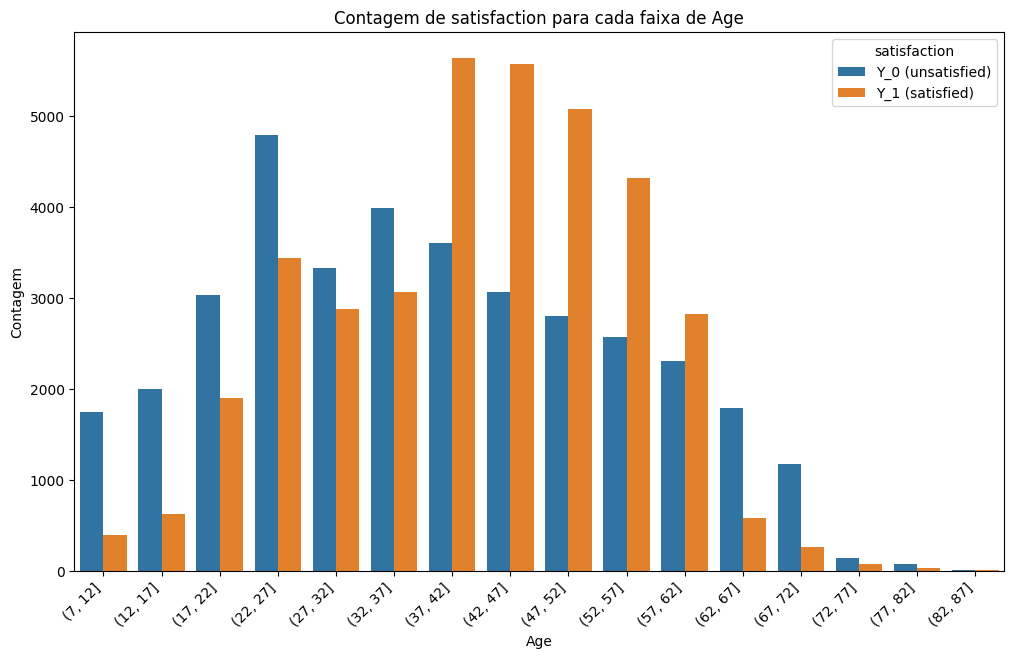

In [8]:
plot_correlation(df_train, 'satisfaction', 'Age', bin_size=5)

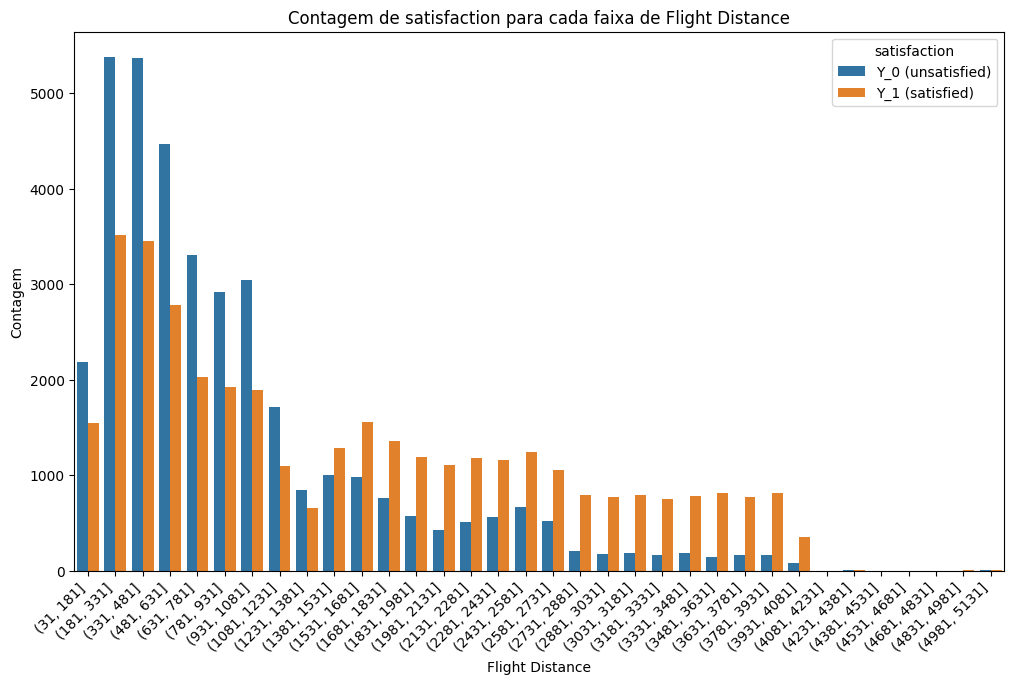

In [9]:
plot_correlation(df_train, 'satisfaction', 'Flight Distance', bin_size=150)

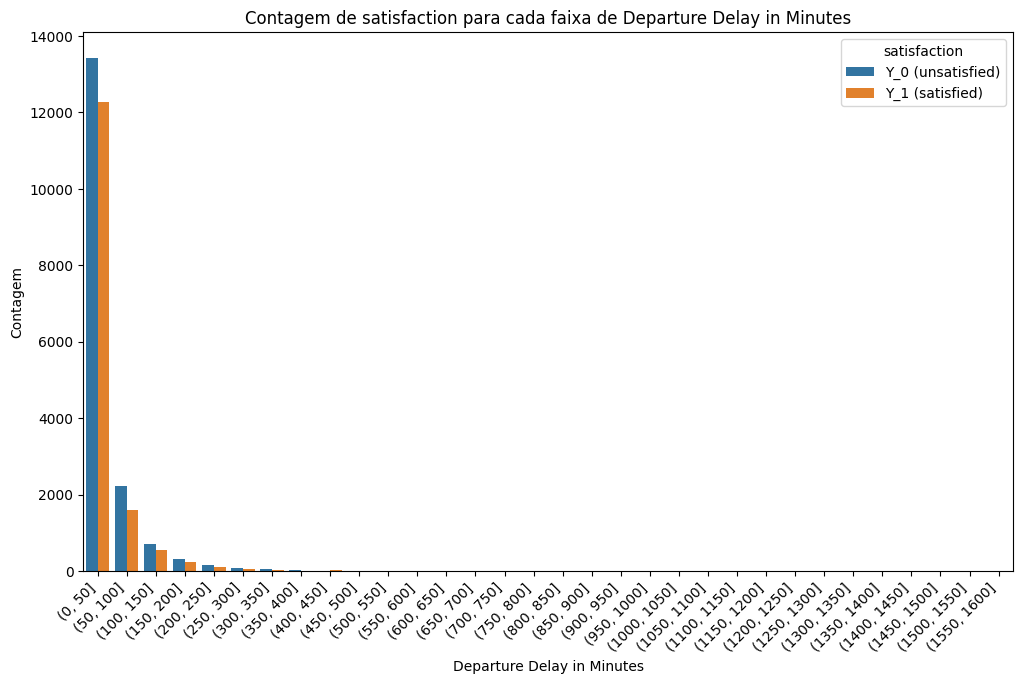

In [10]:
plot_correlation(df_train, 'satisfaction', 'Departure Delay in Minutes', bin_size=50)

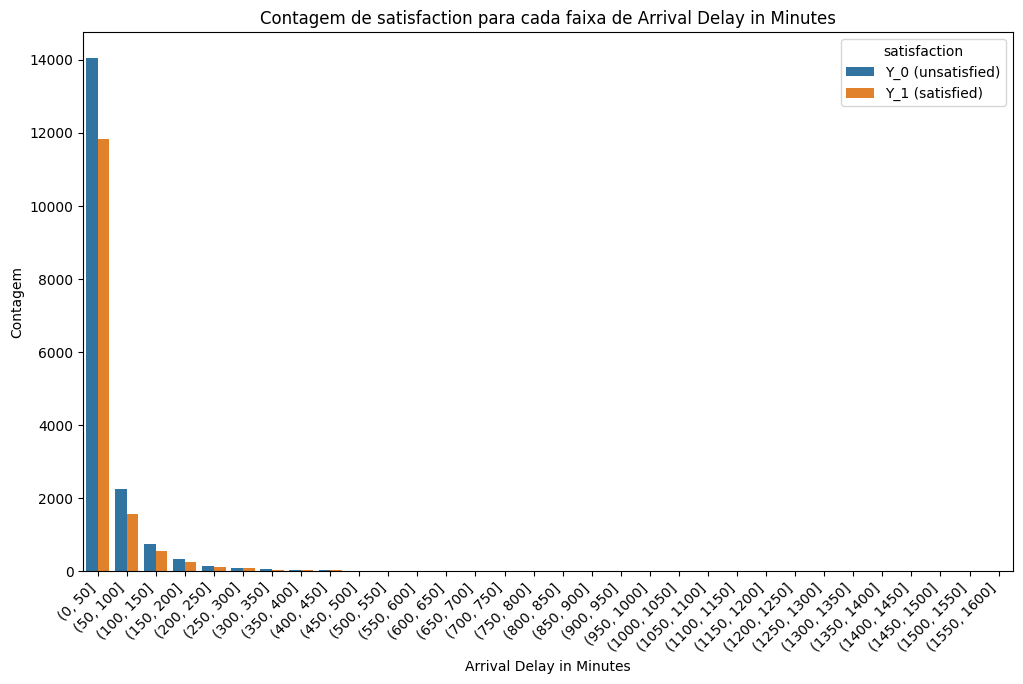

In [11]:
plot_correlation(df_train, 'satisfaction', 'Arrival Delay in Minutes', bin_size=50)

Discretizando as Variáveis

In [12]:
def discretize_col(
        df_train: pd.DataFrame, df_val: pd.DataFrame, df_test: pd.DataFrame, 
        col: str, interval: list) -> list[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    interval = [-np.inf] + interval + [np.inf]
    labels = [f'{interval[i]}-{interval[i+1]}' for i in range(len(interval) - 1)]
    df_train[col] = pd.cut(df_train[col], bins=interval, labels=labels)
    df_val[col] = pd.cut(df_val[col], bins=interval, labels=labels)
    df_test[col] = pd.cut(df_test[col], bins=interval, labels=labels)

    return df_train, df_val, df_test

In [13]:
df_train, df_val, df_test = discretize_col(
    df_train=df_train, df_val=df_val, df_test=df_test, col='Age', interval=[37, 62]
)
df_train, df_val, df_test = discretize_col(
    df_train=df_train, df_val=df_val, df_test=df_test, col='Flight Distance', interval=[1550]
)
df_train, df_val, df_test = discretize_col(
    df_train=df_train, df_val=df_val, df_test=df_test, col='Departure Delay in Minutes', interval=[50, 100]
)
df_train, df_val, df_test = discretize_col(
    df_train=df_train, df_val=df_val, df_test=df_test, col='Arrival Delay in Minutes', interval=[50, 100]
)

In [14]:
df_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,37-62,Business travel,Business,1550-inf,2,1,1,1,...,2,2,2,2,1,2,2,-inf-50,-inf-50,0
1,Male,Loyal Customer,37-62,Business travel,Business,1550-inf,2,1,1,1,...,2,2,2,2,4,2,3,-inf-50,-inf-50,0
2,Female,Loyal Customer,37-62,Business travel,Business,-inf-1550,3,3,3,3,...,2,2,2,2,5,2,3,-inf-50,-inf-50,1
3,Female,Loyal Customer,37-62,Business travel,Business,-inf-1550,5,5,5,5,...,2,2,2,2,3,2,5,-inf-50,-inf-50,1
4,Female,Loyal Customer,-inf-37,Business travel,Business,1550-inf,4,4,5,4,...,4,4,4,4,4,4,5,-inf-50,-inf-50,1


##### Transformando as variáveis categóricas em One-hot-encoding

In [15]:
def one_hot_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, df_val: pd.DataFrame) -> list[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns
    one_hot_df_train = pd.get_dummies(df_train, columns=categorical_columns, dtype=int)

    train_columns = one_hot_df_train.columns

    one_hot_df_val = pd.get_dummies(df_val, columns=categorical_columns, dtype=int)
    one_hot_df_test = pd.get_dummies(df_test, columns=categorical_columns, dtype=int)
    for col in train_columns:
        if col not in one_hot_df_val:
            one_hot_df_val[col] = 0
        if col not in one_hot_df_test:
            one_hot_df_test[col] = 0
    one_hot_df_val = one_hot_df_val[train_columns]
    one_hot_df_test = one_hot_df_test[train_columns]

    return one_hot_df_train, one_hot_df_val, one_hot_df_test

In [16]:
df_train, df_val, df_test = one_hot_encoding(df_train=df_train, df_val=df_val, df_test=df_test)

In [17]:
df_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'satisfaction',
       'Gender_Female', 'Gender_Male', 'Customer Type_Loyal Customer',
       'Customer Type_disloyal Customer', 'Age_-inf-37', 'Age_37-62',
       'Age_62-inf', 'Type of Travel_Business travel',
       'Type of Travel_Personal Travel', 'Class_Business', 'Class_Eco',
       'Class_Eco Plus', 'Flight Distance_-inf-1550',
       'Flight Distance_1550-inf', 'Departure Delay in Minutes_-inf-50',
       'Departure Delay in Minutes_50-100',
       'Departure Delay in Minutes_100-inf',
       'Arrival Delay in Minutes_-inf-50', 'Arrival Delay in Minutes_50-100',
       'Arrival Delay in Minutes_100-inf'],
      dtype='object')

#### Normalização dos Dados

In [18]:
columns_to_normalize = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness'
]

In [19]:
scaler = MinMaxScaler()

In [20]:
scaler.fit(df_train[columns_to_normalize])

MinMaxScaler()

In [21]:
df_train[columns_to_normalize] = scaler.transform(df_train[columns_to_normalize])
df_val[columns_to_normalize] = scaler.transform(df_val[columns_to_normalize])
df_test[columns_to_normalize] = scaler.transform(df_test[columns_to_normalize])

In [22]:
df_train = pd.DataFrame(df_train)
df_val = pd.DataFrame(df_val)
df_test = pd.DataFrame(df_test)

In [23]:
df_train.head()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,...,Class_Eco,Class_Eco Plus,Flight Distance_-inf-1550,Flight Distance_1550-inf,Departure Delay in Minutes_-inf-50,Departure Delay in Minutes_50-100,Departure Delay in Minutes_100-inf,Arrival Delay in Minutes_-inf-50,Arrival Delay in Minutes_50-100,Arrival Delay in Minutes_100-inf
0,0.4,0.2,0.2,0.2,0.4,0.6,0.75,0.4,0.4,0.4,...,0,0,0,1,1,0,0,1,0,0
1,0.4,0.2,0.2,0.2,0.2,0.6,0.75,0.4,0.4,0.4,...,0,0,0,1,1,0,0,1,0,0
2,0.6,0.6,0.6,0.6,0.6,1.0,1.00,0.4,0.4,0.4,...,0,0,1,0,1,0,0,1,0,0
3,1.0,1.0,1.0,1.0,0.6,1.0,1.00,0.4,0.4,0.4,...,0,0,1,0,1,0,0,1,0,0
4,0.8,0.8,1.0,0.8,1.0,0.8,0.75,0.8,0.8,0.8,...,0,0,0,1,1,0,0,1,0,0


##### Reordenando o Dataframe para a variável de saída ficar no final

In [24]:
cols = list(df_train.columns)
cols.remove('satisfaction')
cols.append('satisfaction')

df_train = df_train[cols]
df_val = df_val[cols]
df_test = df_train[cols]